In [1]:
import ot
import sys

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.random as jr

from tqdm import trange

sys.path.append("../")
from lib_jax.gd import mirror_descent, mirror_descent_implicit, gradient_descent
from lib_jax.utils_plot import plot_trajectory
from lib_jax.mirror_maps import EuclideanMirror

from mirror_maps_interaction import LinearMirror, InteractionMirror

key = jr.key(42)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


### Utils Plot

In [3]:
def plot_particles(particles_gd, n_epochs, ax=None, n_plots=5, xmin=-1, xmax=1, ymin=-1, ymax=1, title=False):
    if ax is None:
        fig, ax = plt.subplots(1, n_plots, figsize=(n_plots*3, 3))
    
    epochs = np.linspace(0, n_epochs, n_plots, dtype=int)
    
    for i, e in enumerate(epochs):
        particles = particles_gd[e] - jnp.mean(particles_gd[e], axis=0, keepdims=True)
        ax[i].scatter(particles[:,0], particles[:,1])
        if title:
            ax[i].set_title("Epoch "+str(e), fontsize=13)
        ax[i].set_xlim(xmin, xmax)
        ax[i].set_ylim(ymin, ymax)

### Implicit Scheme

Let $\mathcal{F}:\mathcal{P}_2(\mathbb{R}^d)\to\mathbb{R}$ some functional we want to minimize and $\phi:\mathcal{P}_2(\mathbb{R}^d)\to\mathbb{R}$ a Bregman potential. Define for all $\mu\in\mathcal{P}_2(\mathbb{R}^d)$, $T\in L^2(\mu)$, $\phi_\mu(T)=\phi(T_\#\mu)$, and note $d_{\phi_\mu}$ the $L^2$ Bregman divergence (see Definition 1 in the paper).

We want to solve
\begin{equation}
    T_{k+1} = \mathrm{argmin}_{T\in L^2(\mu_k)}\ d_{\phi_{\mu_k}}(T,\mathrm{Id}) + \tau\langle \nabla_{W_2}\mathcal{F}(\mu_k), T-\mathrm{Id}\rangle_{L^2(\mu_k)} :=\mathcal{J}(T), \quad \mu_{k+1}=(T_{k+1})_\#\mu_k.
\end{equation}

Taking the first order condition, this is equivalent with solving the implicit scheme
\begin{equation}
    \mathcal{J}(T_{k+1}) = \nabla_{W_2}\phi(\mu_{k+1})\circ T_{k+1} - \nabla_{W_2}\phi(\mu_k) + \nabla_{W_2}\mathcal{F}(\mu_k) = 0.
\end{equation}
This can be solved in closed-form e.g. for $\phi(\mu)=\int V\mathrm{d}\mu$ if $\nabla V$ is invertible since $\nabla_{W_2}\phi(\mu)=\nabla V$, but not in general.

When $\nabla_{W_2}\phi(\mu_{k+1})\circ T_{k+1}$ cannot be inverted, we can use the Newton method on particles to approximate the solution.

In [4]:
Sigma_opt =  np.array([[100.,0.],[.0,1]])
Sigma_opt_inv = jnp.linalg.inv(Sigma_opt)

def W(x):
    norm_x2 = jnp.einsum("nmi,ij,nmj -> nm", x, Sigma_opt_inv, x)
    return norm_x2**2 / 4 - norm_x2 / 2

def target(x, y):
    return jnp.mean(W(x[:,None]-y[None]))

@jax.jit
def sum_W(x):
    return jnp.sum(W(x))

grad_W = jax.jit(jax.grad(sum_W))

@jax.jit
def target_grad(x):
    C = x[None] - x[:,None]
    return jnp.mean(grad_W(C), axis=0)


@jax.jit
def precond_gaussian(x):
    return (Sigma_opt @ x.T).T

precond_grad = jax.jit(jax.grad(precond_gaussian))
precond_value_and_grad = jax.jit(jax.value_and_grad(precond_gaussian))

In [5]:
## Mirror maps
P = Sigma_opt
P_ = jnp.linalg.inv(Sigma_opt)

def W_smooth(z, P_):
    if len(z.shape) == 1:
        z = z[None, None]
    elif len(z.shape) == 2:
        z = z[None]

    norm_x2 = jnp.einsum("nmi,ij,nmj -> nm", z, P_, z)
    return norm_x2 **2 / 4 + norm_x2 / 2


@jax.jit
def prec_var(z, P_):
    if len(z.shape) == 1:
        z = z[None, None]
    elif len(z.shape) == 2:
        z = z[None]

    norm_x2 = jnp.einsum("nmi,ij,nmj -> nm", z, P_, z)
    return norm_x2 / 2

### Sanity Check Potential as Mirror Map

The target here is 
\begin{equation}
    \mathcal{W}(\mu) = \frac12 \iint W(x-y)\ \mathrm{d}\mu(x)\mathrm{d}\mu(y),
\end{equation}
with
\begin{equation}
    W(z) = \frac{(z^T\Sigma^{-1}z)^2}{4} - \frac{z^T\Sigma^{-1}z}{2}.
\end{equation}

We use here as mirror map $\phi(\mu) = \int V \mathrm{d}\mu$ with $V(x)=\frac12\|x\|_2^2$ (GD) and $V(x) = \frac12 x^T \Sigma^{-1} x$ (MD). Note that the MD scheme is equivalent with the Preconditioned Gradient Descent (PGD) scheme with $h(x)=\frac12 x^T\Sigma x$.
The resulting schemes are
\begin{equation}
    \mathrm{(GD): }\ T_{k+1} = \mathrm{Id} - \gamma \nabla_{W_2}\mathcal{W}(\mu_k), \quad \mathrm{(MD/PGD): }\ T_{k+1} = \mathrm{Id} - \gamma \Sigma \nabla_{W_2}\mathcal{W}(\mu_k),
\end{equation}
where $\nabla_{W_2}\mathcal{W}(\mu_k) = \nabla W * \mu_k$.

As a sanity check, we verify here that the implicit algorithm using Newton steps can recover the right scheme (MD/PGD).

In [6]:
n_epochs = 250
lr = 0.1
n_particles = 500
d = 2

key = jr.key(42)
x0 = 0.25 * jr.normal(key, (n_particles, d))

In [7]:
mirror = LinearMirror(Sigma_opt)

particles_gd, grads_gd = gradient_descent(target_grad, n_epochs, lr, x0=x0, preconditioner=lambda x: x)

particles_pgd, grads_pgd = gradient_descent(target_grad, n_epochs, lr, x0=x0, preconditioner=lambda x: precond_gaussian(x))

particles_md, grads_md = mirror_descent_implicit(target_grad, mirror, n_epochs, lr, x0=x0)

In [8]:
L = []
L_gd = []
L_pgd = []

for k in range(len(particles_gd)):
    w = target(particles_md[k], particles_md[k])
    L.append(w)

    w = target(particles_gd[k], particles_gd[k])
    L_gd.append(w)

    w = target(particles_pgd[k], particles_pgd[k])
    L_pgd.append(w)

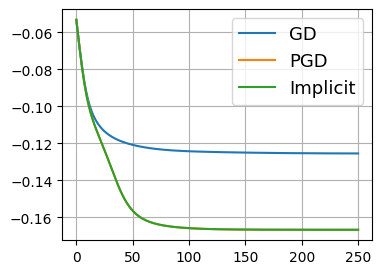

In [9]:
figure, ax = plt.subplots(1, 1, figsize=(4, 3))
plt.plot(L_gd, label="GD")
plt.plot(L_pgd, label="PGD")
plt.plot(L, label="Implicit")
plt.legend(fontsize=13)
plt.grid(True)
plt.show()

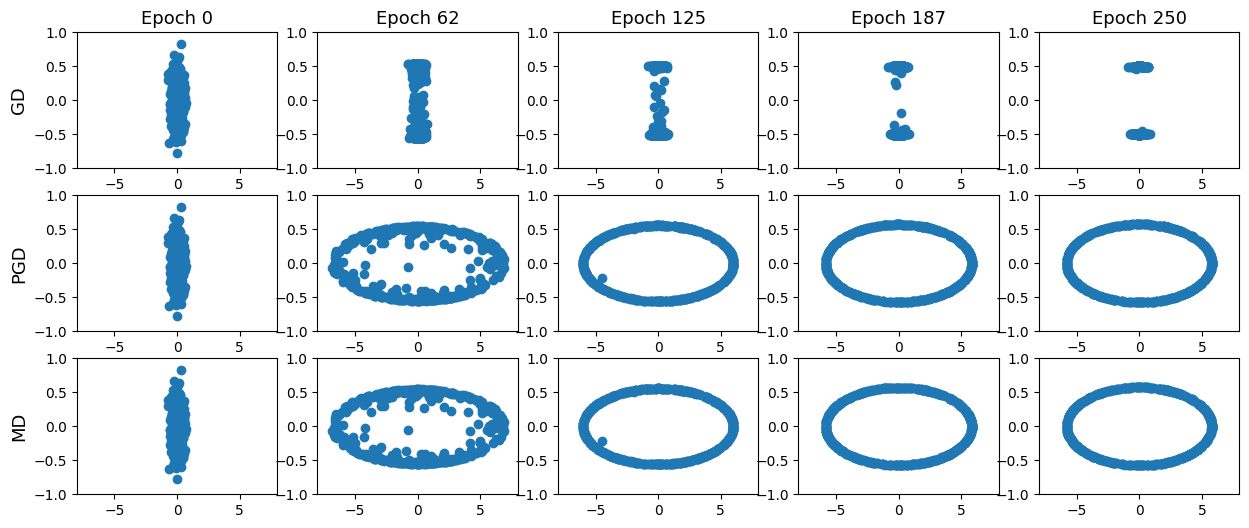

In [10]:
n_plots = 5
xmin, xmax, ymin, ymax = -8, 8, -1, 1

fig, ax = plt.subplots(3, n_plots, figsize=(n_plots*3, 2*3))

plot_particles(particles_gd, n_epochs, ax=ax[0], xmin=xmin, ymin=ymin, xmax=xmax, ymax=ymax, title=True)
plot_particles(particles_pgd, n_epochs, ax=ax[1], xmin=xmin, ymin=ymin, xmax=xmax, ymax=ymax)
plot_particles(particles_md, n_epochs, ax=ax[2], xmin=xmin, ymin=ymin, xmax=xmax, ymax=ymax)

ax[0,0].set_ylabel("GD", fontsize=13)
ax[1,0].set_ylabel("PGD", fontsize=13)
ax[2,0].set_ylabel("MD", fontsize=13)

plt.show()

### Interaction Mirror Maps

We now focus on using interaction functionals for the Bregman potential.

The target here is still
\begin{equation}
    \mathcal{W}(\mu) = \frac12 \iint W(x-y)\ \mathrm{d}\mu(x)\mathrm{d}\mu(y),
\end{equation}
with
\begin{equation}
    W(z) = \frac{\|z\|_2^4}{4} - \frac{\|z\|_2^2}{2}.
\end{equation}

We use here as Bregman potential $\phi(\mu) = \iint K(x-y) \mathrm{d}\mu(x)\mathrm{d}\mu(y)$ with different kernels $K$. For the kernel $K$, we compare $K(x)=\frac12 \|x\|_2^2$ and $K(x)=\frac14\|x\|_2^4 + \frac12\|x\|_2^2$.

We solve the mirror scheme using a Newton method at each step.

In [11]:
lr = 0.1
n_epochs = int(10/lr) # 250
n_particles = 100
d = 2

key = jr.key(42)
x0 = 0.25 * jr.normal(key, (n_particles, d))


Sigma_opt =  np.array([[1.,0.],[.0,1]])
Sigma_opt_inv = jnp.linalg.inv(Sigma_opt)

P = Sigma_opt
P_ = jnp.linalg.inv(Sigma_opt)

In [12]:
mirror = InteractionMirror(lambda z: prec_var(z, P_))
mirror_smooth = InteractionMirror(lambda z: W_smooth(z, P_))

particles, grads = mirror_descent_implicit(target_grad, mirror,n_epochs, lr, x0=x0)
particles_smooth, _ = mirror_descent_implicit(target_grad, mirror_smooth, n_epochs, lr, x0=x0, eps=1e-5)

In [13]:
L = []
L_smooth = []

for k in range(len(particles)):
    w = target(particles[k], particles[k])
    L.append(w)

    w = target(particles_smooth[k], particles_smooth[k])
    L_smooth.append(w)

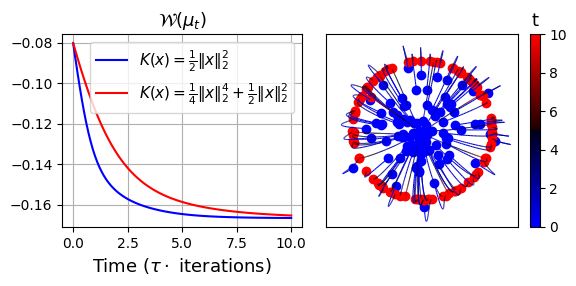

In [14]:
absc = np.linspace(0, n_epochs*lr, n_epochs+1)

figure, ax = plt.subplots(1, 2, figsize=(6.5, 2.5))

plot_trajectory(np.array([particles[k]- jnp.mean(particles[k], axis=0, keepdims=True) for k in range(len(particles))]), 
                log=False, ax=ax[1], fig=fig, colorbar=True, ts=absc[:len(particles)])

xmin, xmax, ymin, ymax = -0.8, 0.8, -0.8, 0.8

ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(ymin, ymax)
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[0].plot(absc, L, label=r"$K(x)=\frac{1}{2}\|x\|_2^2$", c="blue")
ax[0].plot(absc, L_smooth, label=r"$K(x)=\frac{1}{4} \|x\|_2^4 + \frac{1}{2} \|x\|_2^2$", c="red")

# ax[1].set_ylabel(r"$\mathcal{W}(\mu_t)$", fontsize=13)
ax[0].set_title(r"$\mathcal{W}(\mu_t)$", fontsize=13)

ax[0].set_xlabel(r"Time ($\tau \cdot$ iterations)", fontsize=13)
ax[0].legend(fontsize=11)
ax[0].grid(True)
plt.subplots_adjust(wspace=0.1)
# plt.subplots_adjust(wspace=0.3)

fig.tight_layout()
# plt.savefig("./Mirror_interaction.pdf", format="pdf", bbox_inches="tight") #, dpi=150)
plt.show()

### Ill Conditioned Mirror Maps

The target here is still
\begin{equation}
    \mathcal{W}(\mu) = \frac12 \iint W(x-y)\ \mathrm{d}\mu(x)\mathrm{d}\mu(y),
\end{equation}
but with a ill conditioned kernel, i.e. for $\Sigma=\mathrm{diag}(100,1)$,
\begin{equation}
    W(z) = \frac{(z^T\Sigma^{-1}z)^2}{4} - \frac{z^T\Sigma^{-1}z}{2}.
\end{equation}


We use here as mirror map $\phi(\mu) = \iint K(x-y) \mathrm{d}\mu(x)\mathrm{d}\mu(y)$ with different kernels $K$. For the kernel $K$, we compare $K_2(x)=\frac12 \|x\|_2^2$ and $K_4(x)=\frac14\|x\|_2^4 + \frac12\|x\|_2^2$, and their ideally preconditioned versions $K_2^\Sigma(x)=\frac12 x^T\Sigma^{-1}x$ and $K_4^\Sigma(x) = \frac14 (x^T \Sigma^{-1}x)^2 + \frac12 x^T\Sigma^{-1}x$.

We solve the mirror scheme using a Newton method at each step.

In [15]:
Sigma_opt = np.array([[100.,0.],[.0,1]])
Sigma_opt_inv = jnp.linalg.inv(Sigma_opt)

def W(x):
    norm_x2 = jnp.einsum("nmi,ij,nmj -> nm", x, Sigma_opt_inv, x)
    return norm_x2**2 / 4 - norm_x2 / 2

def target(x, y):
    return jnp.mean(W(x[:,None]-y[None]))

@jax.jit
def sum_W(x):
    return jnp.sum(W(x))

grad_W = jax.jit(jax.grad(sum_W))

@jax.jit
def target_grad(x):
    C = x[None] - x[:,None]
    return jnp.mean(grad_W(C), axis=0)


@jax.jit
def precond_gaussian(x):
    return (Sigma_opt @ x.T).T

precond_grad = jax.jit(jax.grad(precond_gaussian))
precond_value_and_grad = jax.jit(jax.value_and_grad(precond_gaussian))

In [16]:
## Mirror maps
P = Sigma_opt
P_ = jnp.linalg.inv(Sigma_opt)

def W_smooth(z, P_):
    if len(z.shape) == 1:
        z = z[None, None]
    elif len(z.shape) == 2:
        z = z[None]

    norm_x2 = jnp.einsum("nmi,ij,nmj -> nm", z, P_, z)
    return norm_x2 **2 / 4 + norm_x2 / 2


@jax.jit
def prec_var(z, P_):
    if len(z.shape) == 1:
        z = z[None, None]
    elif len(z.shape) == 2:
        z = z[None]

    norm_x2 = jnp.einsum("nmi,ij,nmj -> nm", z, P_, z)
    return norm_x2 / 2

In [17]:
lr = 0.1
n_epochs = int(12/lr) # int(10/lr) # 250
n_particles = 100
d = 2

key = jr.key(42)
x0 = 0.25 * jr.normal(key, (n_particles, d))

In [18]:
mirror = InteractionMirror(lambda z: prec_var(z, jnp.eye(2)))
mirror_prec = InteractionMirror(lambda z: prec_var(z, P_))
mirror_smooth = InteractionMirror(lambda z: W_smooth(z, jnp.eye(2)))
mirror_smooth_prec = InteractionMirror(lambda z: W_smooth(z, P_))

mirror_euc = EuclideanMirror()

particles_V, grad = mirror_descent(target_grad, mirror_euc, n_epochs, lr, x0=x0)
particles_pgd, grads_pgd = gradient_descent(target_grad, n_epochs, lr, n_particles, d, x0=x0, 
                                            preconditioner=lambda x: precond_gaussian(x))

particles, grads = mirror_descent_implicit(target_grad, mirror,n_epochs, lr, x0=x0)
particles_prec, _ = mirror_descent_implicit(target_grad, mirror_prec, n_epochs, lr, x0=x0)
particles_smooth, _ = mirror_descent_implicit(target_grad, mirror_smooth, n_epochs, lr, x0=x0, eps=1e-5)
particles_smooth_prec, _ = mirror_descent_implicit(target_grad, mirror_smooth_prec, n_epochs, lr, x0=x0, eps=1e-5)

In [19]:
L = []
L_prec = []

L_smooth = []
L_smooth_prec = []

L_V = []
L_V_pgd = []

for k in range(len(particles)):
    w = target(particles[k], particles[k])
    L.append(w)

    w = target(particles_prec[k], particles_prec[k])
    L_prec.append(w)

    w = target(particles_smooth[k], particles_smooth[k])
    L_smooth.append(w)

    w = target(particles_smooth_prec[k], particles_smooth_prec[k])
    L_smooth_prec.append(w)

    w = target(particles_V[k], particles_V[k])
    L_V.append(w)

    w = target(particles_pgd[k], particles_pgd[k])
    L_V_pgd.append(w)

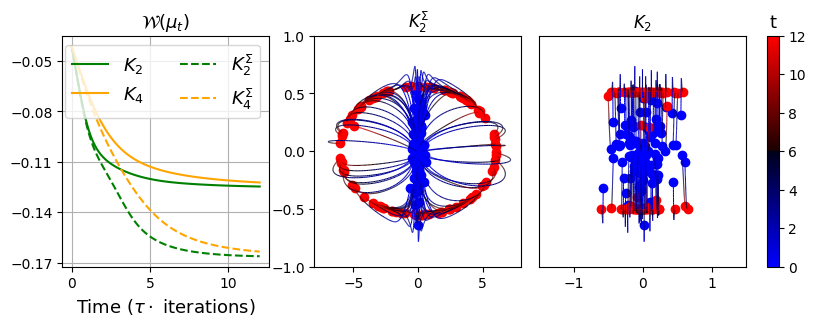

In [20]:
absc = np.linspace(0, n_epochs*lr, n_epochs+1)
xmin, xmax, ymin, ymax = -8, 8, -1, 1


fig, ax = plt.subplots(1, 3, figsize=(11 * 3 / 3, 3))



ax[0].plot(absc, L, label=r"$K_2$", c="green")
ax[0].plot(absc, L_smooth, label=r"$K_4$", c="orange")

ax[0].plot(absc, L_prec, "--", label=r"$K_2^\Sigma$", c="green")
ax[0].plot(absc, L_smooth_prec, "--", label=r"$K_4^\Sigma$", c="orange")

ax[0].set_yticks([-0.05,-0.08,-0.11,-0.14,-0.17])

ax[0].set_title(r"$\mathcal{W}(\mu_t)$", fontsize=13)

ax[0].set_xlabel(r"Time ($\tau \cdot$ iterations)", fontsize=13)
ax[0].legend(fontsize=13, ncols=2, loc="upper right")
ax[0].grid(True)


plot_trajectory(np.array([particles_prec[k]- np.mean(particles_prec[k], axis=0, keepdims=True) for k in range(len(particles))]), 
                ts=absc[:len(particles)], ax=ax[1])

ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(ymin, ymax)
ax[1].set_title(r"$K_2^\Sigma$")
ax[1].set_yticks([1,0.5,0,-0.5,-1])

line = plot_trajectory(np.array([particles[k]- np.mean(particles[k], axis=0, keepdims=True) for k in range(len(particles))]), 
                       ax=ax[2], ts=absc[:len(particles)])

ax[2].set_xlim(-1.5, 1.5)
ax[2].set_ylim(ymin, ymax)
ax[2].set_title(r"$K_2$")
ax[2].set_yticks([])


pos1 = ax[0].get_position()  # Get the original position of the first subplot
pos2 = ax[1].get_position()  # Get the original position of the second subplot
pos3 = ax[2].get_position()  # Get the original position of the third subplot

ax[1].set_position([pos1.x1 + 0.05, pos2.y0, pos2.width, pos2.height])  # Adjust ax[1] position
ax[2].set_position([ax[1].get_position().x1 + 0.02, pos3.y0, pos3.width, pos3.height])  # Adjust ax[2] position

cb = fig.colorbar(line, ax=ax, pad=0.025)
cb.ax.set_title("t", fontsize=13)
plt.show()

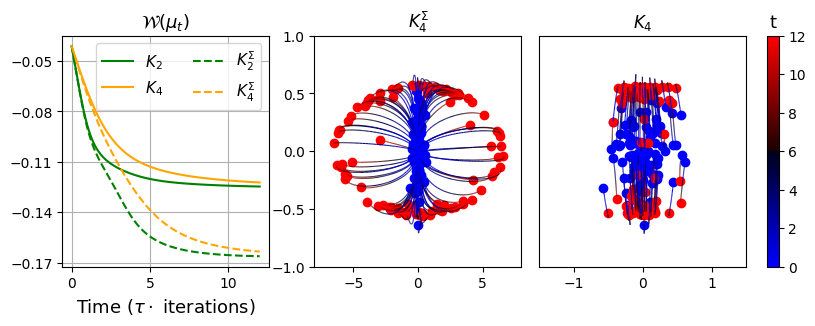

In [21]:
absc = np.linspace(0, n_epochs*lr, n_epochs+1)
xmin, xmax, ymin, ymax = -8, 8, -1, 1


fig, ax = plt.subplots(1, 3, figsize=(11 * 3 / 3, 3))

ax[0].plot(absc, L, label=r"$K_2$", c="green")
ax[0].plot(absc, L_smooth, label=r"$K_4$", c="orange")

ax[0].plot(absc, L_prec, "--", label=r"$K_2^\Sigma$", c="green")
ax[0].plot(absc, L_smooth_prec, "--", label=r"$K_4^\Sigma$", c="orange")

ax[0].set_yticks([-0.05,-0.08,-0.11,-0.14,-0.17])
ax[0].set_title(r"$\mathcal{W}(\mu_t)$", fontsize=13)

ax[0].set_xlabel(r"Time ($\tau \cdot$ iterations)", fontsize=13)
ax[0].legend(fontsize=11, ncols=2, loc="upper right")
ax[0].grid(True)


plot_trajectory(np.array([particles_smooth_prec[k]- np.mean(particles_smooth_prec[k], axis=0, keepdims=True) for k in range(len(particles))]), 
                ts=absc[:len(particles)], ax=ax[1])

ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(ymin, ymax)
ax[1].set_title(r"$K_4^\Sigma$")
ax[1].set_yticks([1,0.5,0,-0.5,-1])

line = plot_trajectory(np.array([particles_smooth[k]- np.mean(particles_smooth[k], axis=0, keepdims=True) for k in range(len(particles))]), 
                       ax=ax[2], ts=absc[:len(particles)])

ax[2].set_xlim(-1.5, 1.5)
ax[2].set_ylim(ymin, ymax)
ax[2].set_title(r"$K_4$")
ax[2].set_yticks([])


pos1 = ax[0].get_position()  # Get the original position of the first subplot
pos2 = ax[1].get_position()  # Get the original position of the second subplot
pos3 = ax[2].get_position()  # Get the original position of the third subplot

ax[1].set_position([pos1.x1 + 0.05, pos2.y0, pos2.width, pos2.height])  # Adjust ax[1] position
ax[2].set_position([ax[1].get_position().x1 + 0.02, pos3.y0, pos3.width, pos3.height])  # Adjust ax[2] position

cb = fig.colorbar(line, ax=ax, pad=0.025)
cb.ax.set_title("t", fontsize=13)

plt.show()

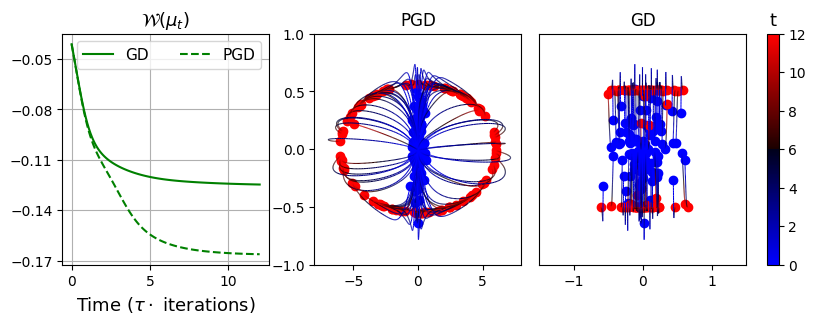

In [22]:
absc = np.linspace(0, n_epochs*lr, n_epochs+1)
xmin, xmax, ymin, ymax = -8, 8, -1, 1


fig, ax = plt.subplots(1, 3, figsize=(11 * 3 / 3, 3))


ax[0].plot(absc, L_V, label=r"GD", c="green")
ax[0].plot(absc, L_V_pgd, "--", label=r"PGD", c="green")

ax[0].set_yticks([-0.05,-0.08,-0.11,-0.14,-0.17])
ax[0].set_title(r"$\mathcal{W}(\mu_t)$", fontsize=13)
ax[0].set_xlabel(r"Time ($\tau \cdot$ iterations)", fontsize=13)
ax[0].legend(fontsize=11, ncols=2, loc="upper right")
ax[0].grid(True)

plot_trajectory(np.array([particles_pgd[k]- np.mean(particles_pgd[k], axis=0, keepdims=True) for k in range(len(particles))]), 
                ts=absc[:len(particles)], ax=ax[1])

ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(ymin, ymax)
ax[1].set_title(r"PGD")
ax[1].set_yticks([1,0.5,0,-0.5,-1])

line = plot_trajectory(np.array([particles_V[k]- np.mean(particles_V[k], axis=0, keepdims=True) for k in range(len(particles))]), 
                       ax=ax[2], ts=absc[:len(particles)])



ax[2].set_xlim(-1.5, 1.5)
ax[2].set_ylim(ymin, ymax)
ax[2].set_title(r"GD")
ax[2].set_yticks([])


pos1 = ax[0].get_position()  # Get the original position of the first subplot
pos2 = ax[1].get_position()  # Get the original position of the second subplot
pos3 = ax[2].get_position()  # Get the original position of the third subplot

ax[1].set_position([pos1.x1 + 0.05, pos2.y0, pos2.width, pos2.height])  # Adjust ax[1] position
ax[2].set_position([ax[1].get_position().x1 + 0.02, pos3.y0, pos3.width, pos3.height])  # Adjust ax[2] position

cb = fig.colorbar(line, ax=ax, pad=0.025)
cb.ax.set_title("t", fontsize=13)

plt.show()